In [118]:
from src.gru.generator import EncoderDecoderV3
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gru_pca import encode, transform, read_data
from sklearn.decomposition import PCA

model_path = ('models/GRUv3_czosnek/epoch_60.pt')
model_name = model_path.split('/')[1]
epoch = model_path.split('_')[-1].split('.')[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = EncoderDecoderV3(fp_size=4860, 
                         encoding_size=32, 
                         hidden_size=512, 
                         num_layers=3, 
                         output_size=42, 
                         dropout=0,
                         teacher_ratio = 0.0,
                         random_seed=42).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

Using device: cuda


<All keys matched successfully>

In [91]:
df = pd.read_parquet('data/train_data/combined_dataset.parquet').sample(100000)
mus, _ = encode(df, model, device)

  3%|▎         | 3/98 [00:02<01:08,  1.39it/s]


KeyboardInterrupt: 

In [119]:
pca = PCA(n_components=2, random_state=42)
pca.fit(mus)
all_results = transform(mus, pca)
d2_encoded = encode(read_data('data/activity_data/d2_klek_100nM.parquet'), model, device)
d2_results = transform(d2_encoded[0], pca)

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


In [120]:
import rdkit.Chem as Chem
from src.utils.vectorizer import SELFIESVectorizer
vectorizer = SELFIESVectorizer()

smiles = [
    'CN(C)CCCN1C2=CC=CC=C2SC3=CC=CC=C31', # promazine
    'CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21', # chlorpromazine
    'CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C(F)(F)F', # triflupromazine
    'FC(F)(F)c2cc1N(c3c(Sc1cc2)cccc3)CCCN4CCN(CCO)CC4', # fluphenazine
    'CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=CC=CC=C42', # perazine
    'CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)(F)F' # trifluperazine
]

molecule_names = [
    'promazine',
    'chlorpromazine',
    'triflupromazine',
    'fluphenazine',
    'perazine',
    'trifluperazine'
]

mols = [Chem.MolFromSmiles(x) for x in smiles]

def calculate_sparse_fingerprint(mol):
    keys = 'data/KlekFP_keys.txt'
    klek_keys = [line.strip() for line in open(keys)]
    klek_keys_mols = list(map(Chem.MolFromSmarts, klek_keys))
    mol_list = []
    for i, key in enumerate(klek_keys_mols):
        if mol.HasSubstructMatch(key):
            mol_list.append(1)
        else:
            mol_list.append(0)
    return mol_list

fps = [torch.Tensor(calculate_sparse_fingerprint(mol)) for mol in mols]
fps = [fp.unsqueeze(0).to(device) for fp in fps]
fps_tensor = torch.cat(fps, dim=0)
fp_encoded, _ = model.encoder(fps_tensor)

out = transform(fp_encoded.detach().cpu().numpy(), pca).T
out = [(x, y, name) for (x, y), name in zip(out, molecule_names)]

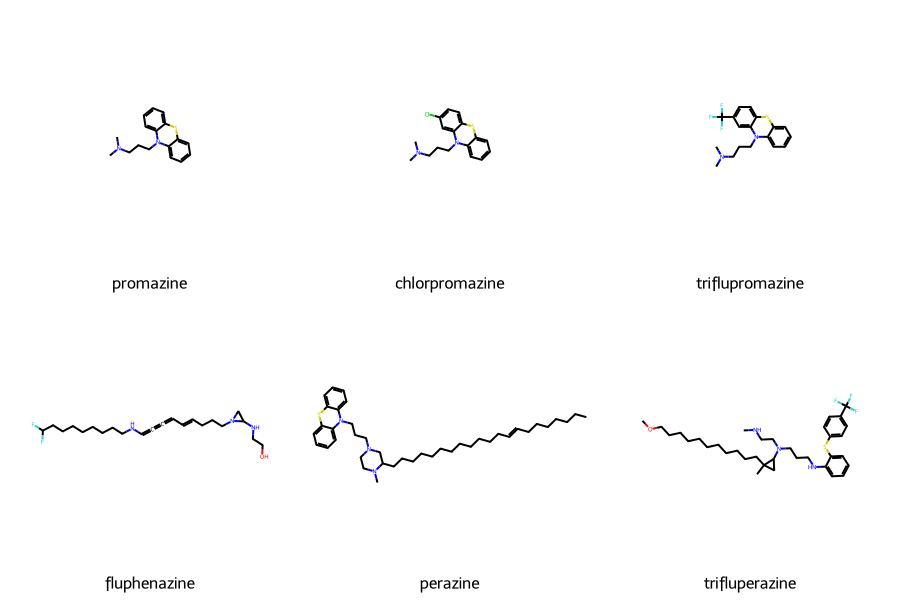

In [121]:
import selfies as sf

preds, _ = model(fp_encoded, None, encode_first=False, )
preds = preds.detach().cpu().numpy()
preds = [vectorizer.devectorize(pred, remove_special=True) for pred in preds]
preds = [sf.decoder(x) for x in preds]
preds = [Chem.MolFromSmiles(pred) for pred in preds]
img = Chem.Draw.MolsToGridImage(preds, molsPerRow=3, subImgSize=(300, 300), legends=molecule_names)
img

<Figure size 640x480 with 0 Axes>

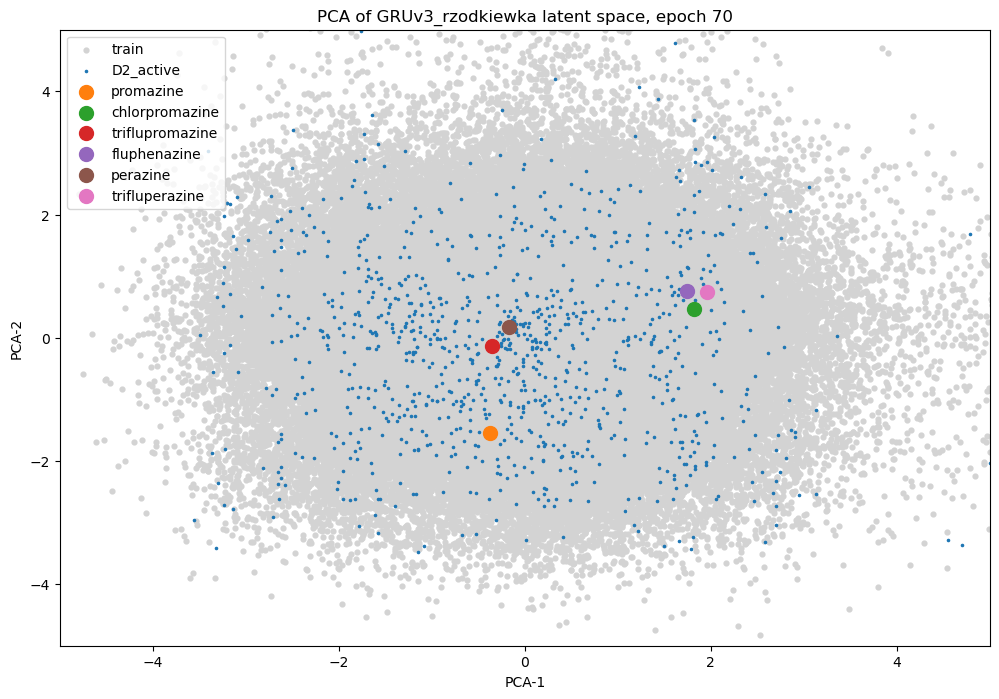

In [65]:
marker_size = 10

plt.clf()
fig = plt.figure(figsize=(12, 8))
plt.scatter(*all_results, marker='o', label='train', s=12, c='lightgrey')
plt.scatter(*d2_results, marker=f'.', label='D2_active', s=marker_size)
for i, (x, y, name) in enumerate(out):
    plt.scatter(x, y, marker=f'o', s=100, label=name)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.legend(loc='upper left')
plt.title(f'''PCA of {model_name} latent space, epoch {epoch}''')
plt.savefig(f'PCAs/{model_name}_epoch_{epoch}.png')
plt.show()